# 读取数据

In [1]:
import pickle
road_zip={}
with open('../data/road_zip.pkl','rb') as f:
    road_zip=pickle.load(f)
road_dict={}
for no,road in enumerate(road_zip):
    road_dict[road]={'id':no}

查询道路的坐标

In [2]:
import requests
from fake_useragent import UserAgent
import json
import threading
import queue
import time
q = queue.Queue()
thread_list = []

def road_geomsg(road):
    road_location=(0.0,0.0)
    #爬取道路中心点
    server_host='http://106.11.43.113/v3/geocode/geo'
    parameters={
        'key':'111d1e3797ffa20c7d44a42ab0bed3fd',
        'city':'上海市',
        'address':road
    }
    response=requests.get(url=server_host,
                         headers={'User-Agent':UserAgent(path='fakeuseragent.json').random},
                         params=parameters)
    response.encoding=response.apparent_encoding
    res=json.loads(response.text)
    if len(res['geocodes'])>0:
        location=res['geocodes'][0]['location'].split(',')
        road_location=(float(location[0]),float(location[1]))
        
    #爬取道路polyline
    server_host='http://106.11.43.113/v3/traffic/status/road'
    parameters={
        'key':'111d1e3797ffa20c7d44a42ab0bed3fd',
        'city':'上海市',
        'name':road,
        'level':5,
        'extensions':'all'
    }
    response=requests.get(url=server_host,
                         headers={'User-Agent':UserAgent(path='fakeuseragent.json').random},
                         params=parameters)
    response.encoding=response.apparent_encoding
    res=json.loads(response.text)
    if 'trafficinfo' in res and 'roads' in res['trafficinfo']:
        for road_msg in res['trafficinfo']['roads']:
            if 'polyline' in road_msg:
                polyline=road_msg['polyline'].split(';')
                polyline=[(float(loc.split(',')[0]),float(loc.split(',')[1])) for loc in polyline]
                q.put({'road':road,'direction':road_msg['direction'],'location':road_location,'polyline':polyline})
    else:
        print(res)
            
road_names=[]
for road in road_dict:
    if road[0] not in road_names:
        road_names.append(road[0])

for name in road_names:
    thread=threading.Thread(target=road_geomsg, args=(name,))
    thread_list.append(thread)
    thread.start()
    time.sleep(0.1)
    
for thread in thread_list:
    thread.join()
thread_list.clear()

while not q.empty():
    msg=q.get()
    if (msg['road'],msg['direction']) in road_dict:
        road_dict[(msg['road'],msg['direction'])]['location']=msg['location']
        road_dict[(msg['road'],msg['direction'])]['polyline']=msg['polyline']
        
import pickle
with open('../data/road_dict.pkl','wb') as f:
    pickle.dump(road_dict, f)

ModuleNotFoundError: No module named 'fake_useragent'

查询上海市行政区边界polyline

In [6]:
import numpy as np
server_host='https://restapi.amap.com/v3/config/district'
parameters={
    'key':'111d1e3797ffa20c7d44a42ab0bed3fd',
    'keywords':'上海市',
    'subdistrict':0,
    'extensions':'all'
}
response=requests.get(url=server_host,
                     headers={'User-Agent':UserAgent(path='fakeuseragent.json').random},
                     params=parameters)
response.encoding=response.apparent_encoding
res=json.loads(response.text)
poly_lines=res['districts'][0]['polyline'].split('|')
poly_lines=[line.split(';') for line in poly_lines]
for i in range(len(poly_lines)):
    poly_lines[i]=np.array([point.split(',') for point in poly_lines[i]],dtype=float).T
sh_poly_lines=poly_lines

# 统计分析

## 绘制光栅图

In [7]:
import cv2 as cv
import numpy as np
sample=np.array(list(road_zip.values()))
sample=sample.swapaxes(0,1)
sample=np.concatenate(sample,axis=1)
image=85*sample[:,:,0]
# image=255*(np.ones_like(sample[:,:,1])-sample[:,:,1])
cv.imwrite("../img/raster.png", image)

True

## 统计拥堵发生的时间特征

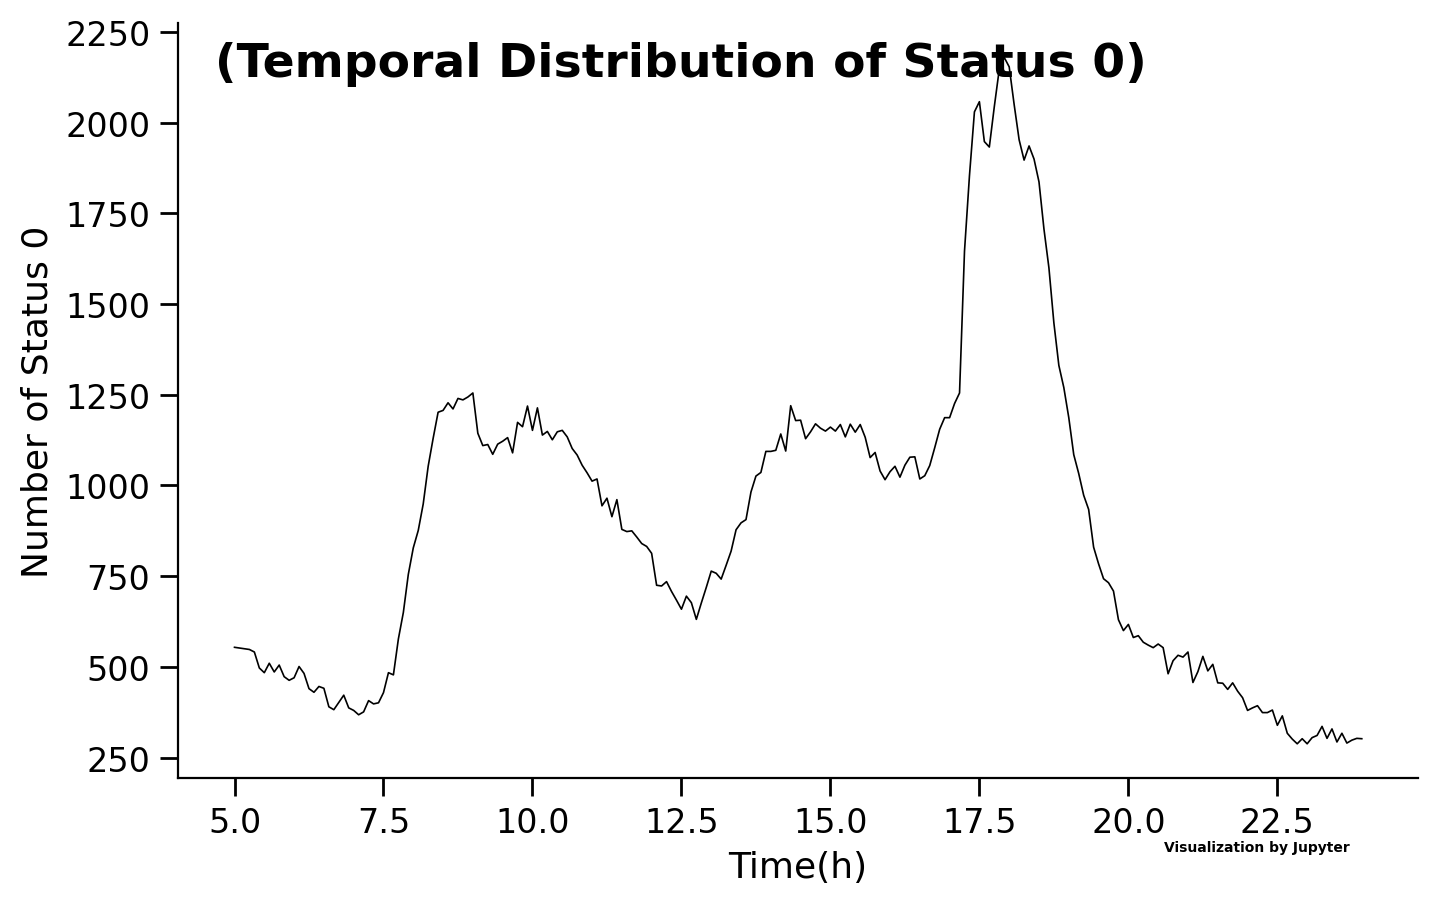

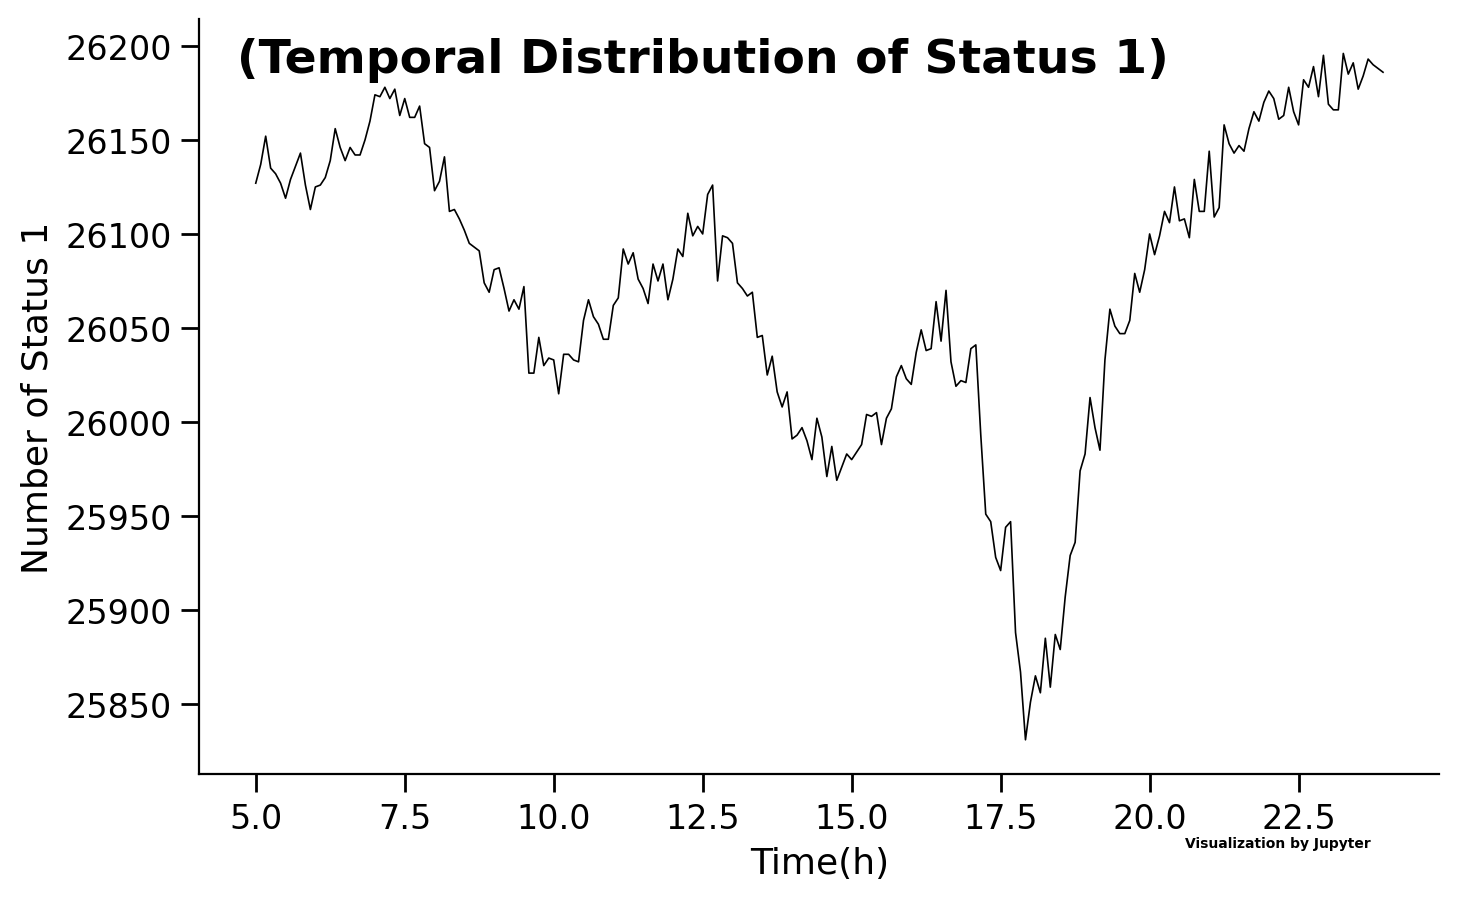

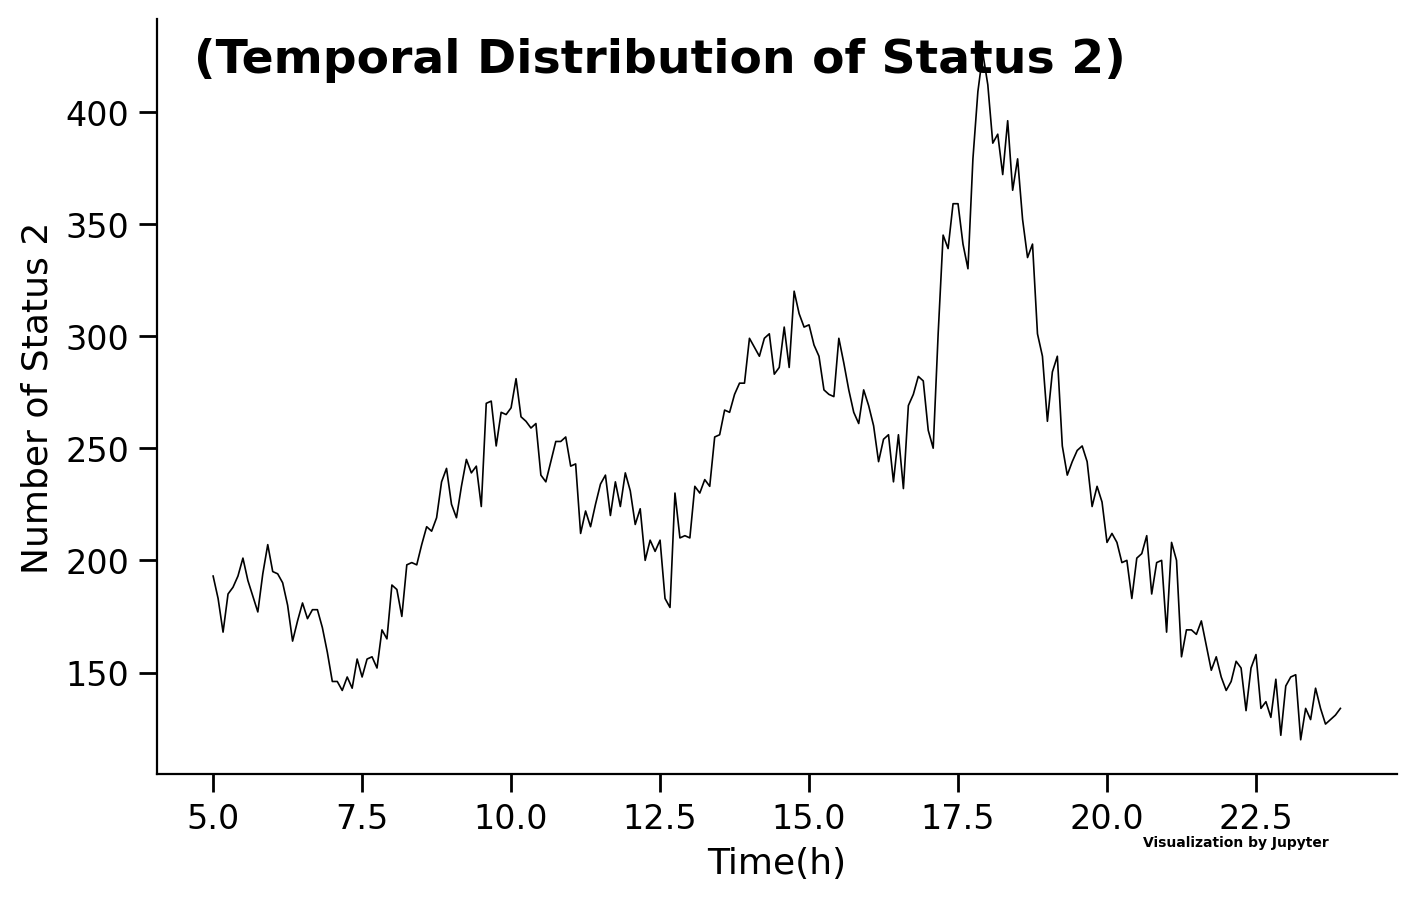

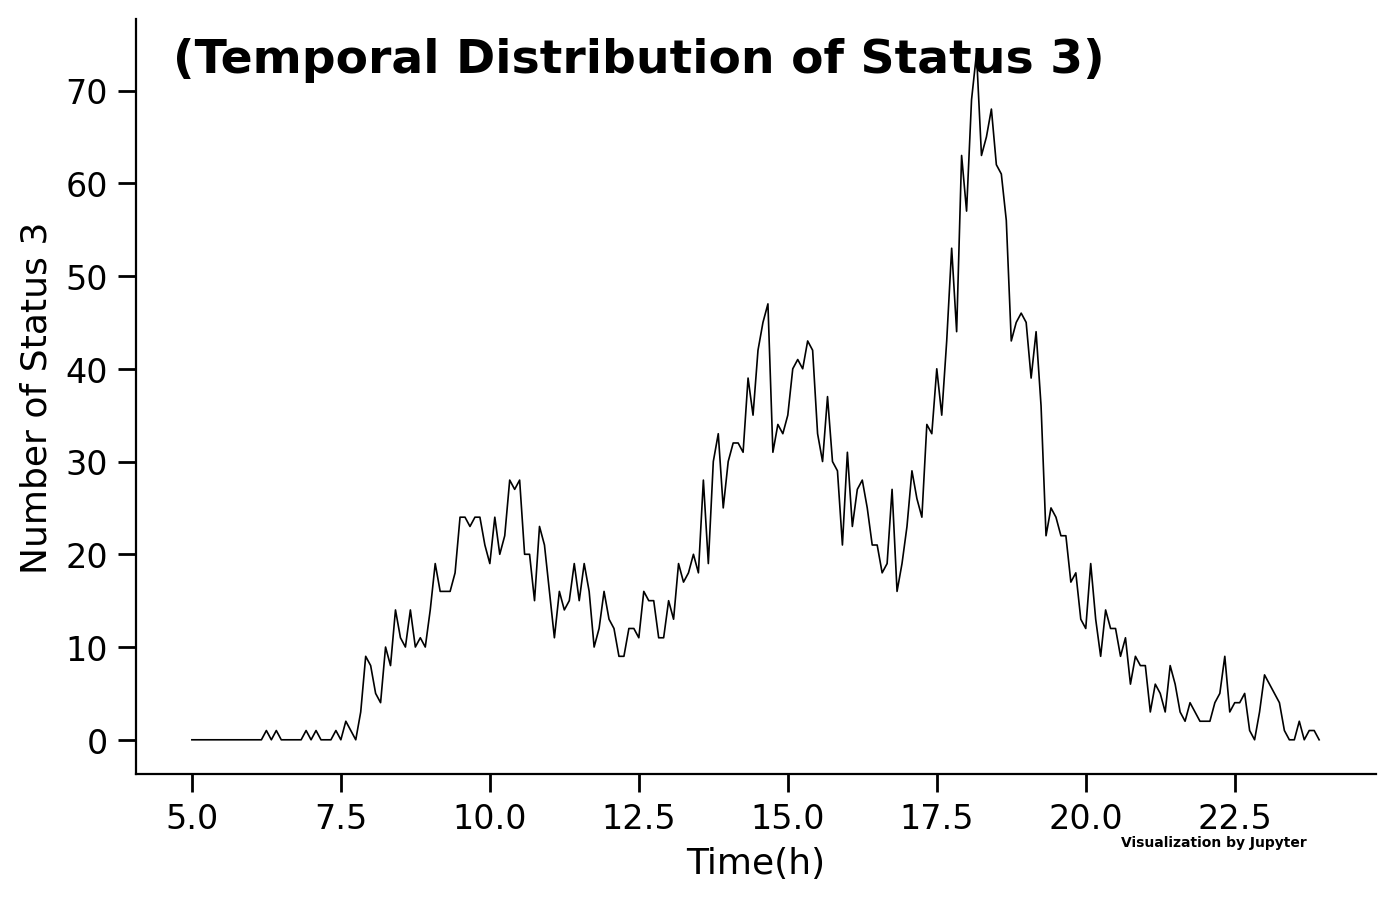

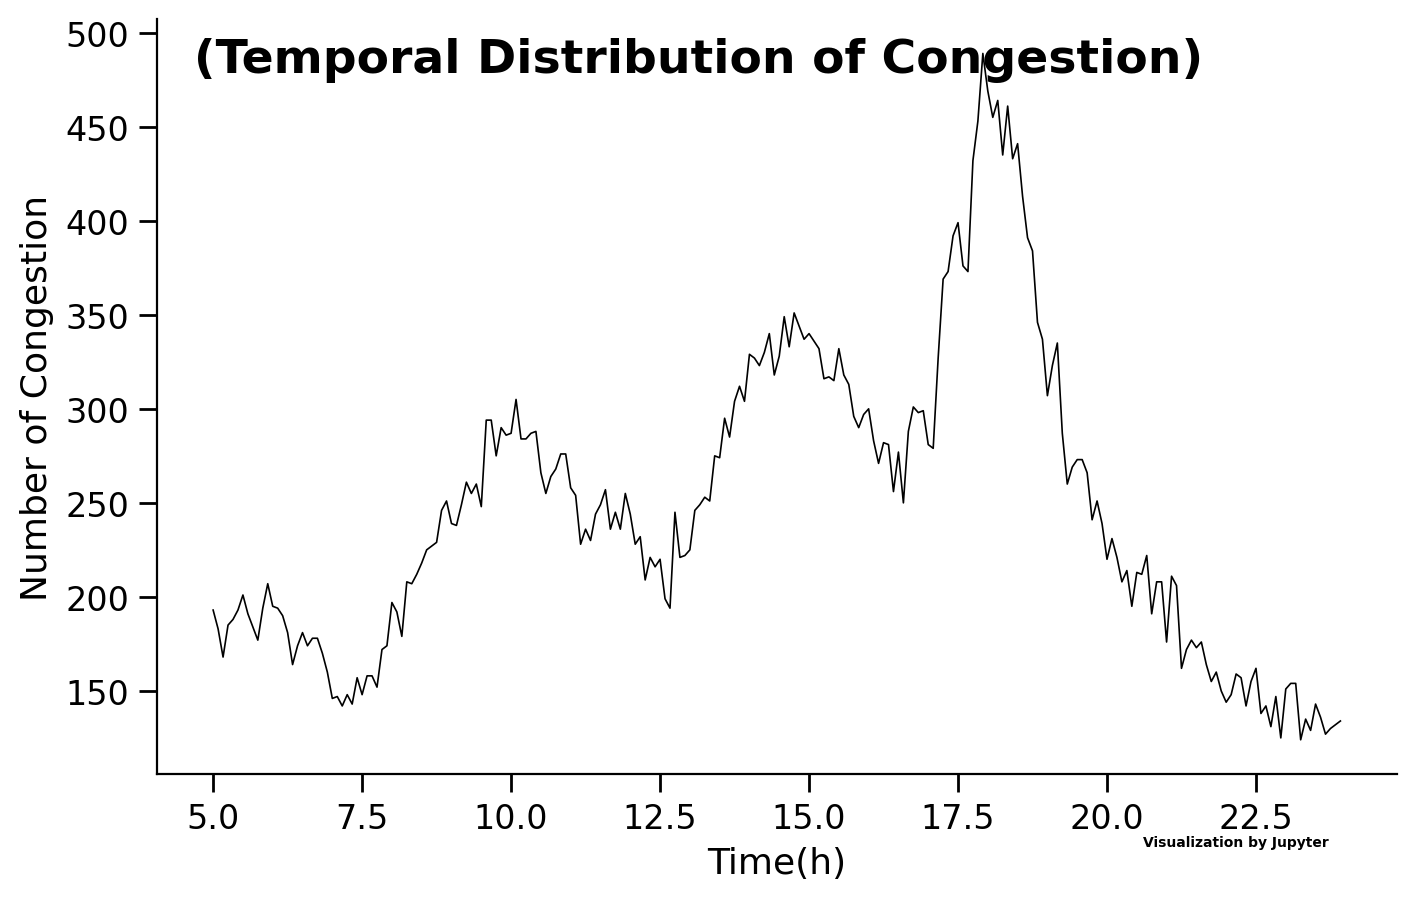

In [10]:
import matplotlib.pyplot as plt
from collections import Counter
data=np.array(list(road_zip.values()))[:,:,:,0]
data=np.concatenate(data,axis=0)
data=data.T
result={0:[],1:[],2:[],3:[]}
for index,time_data in enumerate(data):
    cnt=Counter(time_data)
    for i in result:
        if i in cnt:
            result[i].append(cnt[i])
        else:
            result[i].append(0)
#把缺失值算作1（畅通）
result[1]=list(np.array(result[0])+np.array(result[1]))
label = [(i*5)/60+5 for i in range(len(result[0]))]
for index,value in result.items():
    fig,ax = plt.subplots(figsize=(8,5),dpi=200)
    ax.plot(label, value, color='black', linewidth=.6)
    ax.tick_params(direction='out',labelsize=12,length=6.5,width=1,top=False,right=False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylabel(f'Number of Status {index}',fontsize=13)
    ax.set_xlabel('Time(h)',fontsize=13)
    text_font = {'size':'17','weight':'bold','color':'black'}
    ax.text(.03,.93,f'(Temporal Distribution of Status {index})',transform = ax.transAxes,fontdict=text_font,zorder=4)
    ax.text(.87,-.08,'\nVisualization by Jupyter',transform = ax.transAxes, ha='center', va='center',fontsize = 5,color='black',fontweight='bold')
    fig.show()

    
congestion=list(np.array(result[2])+np.array(result[3]))
fig,ax = plt.subplots(figsize=(8,5),dpi=200)
ax.plot(label, congestion, color='black', linewidth=.6)
ax.tick_params(direction='out',labelsize=12,length=6.5,width=1,top=False,right=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(f'Number of Congestion',fontsize=13)
ax.set_xlabel('Time(h)',fontsize=13)
text_font = {'size':'17','weight':'bold','color':'black'}
ax.text(.03,.93,f'(Temporal Distribution of Congestion)',transform = ax.transAxes,fontdict=text_font,zorder=4)
ax.text(.87,-.08,'\nVisualization by Jupyter',transform = ax.transAxes, ha='center', va='center',fontsize = 5,color='black',fontweight='bold')
fig.show()


## 统计拥堵发生的持续时间特征


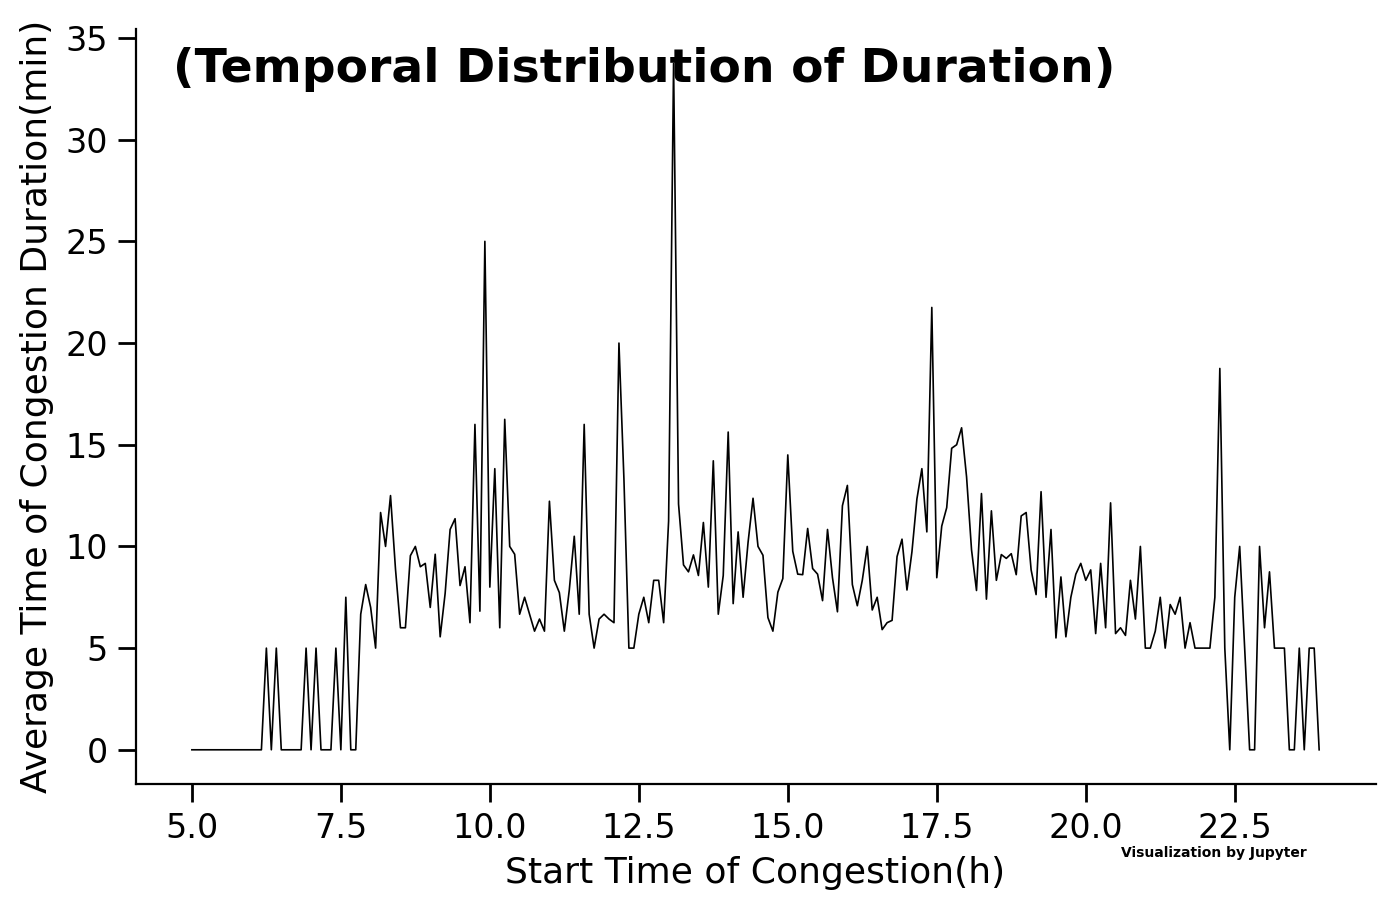

In [11]:
import matplotlib.pyplot as plt
data=np.array(list(road_zip.values()))[:,:,:,0]
result=[]
for road in data:
    for date in road:
        start_time=0
        duration=0
        for index,item in enumerate(date):
            if start_time==0 and item>2:#统计拥堵等级为3的事件
                start_time=index
            if start_time!=0 and item<=2:
                duration=index-start_time
                #如果是range(1)则代表计算拥堵开始时刻的拥堵时间
                #如果是range(duration)则代表计算发生拥堵后每个时刻的拥堵时间
                for i in range(1):
                    result.append({'start_time':start_time+i,'duration':duration-i})
                start_time=0
                duration=0             
statistic={}
for item in result:
    if item['start_time'] in statistic:
        statistic[item['start_time']].append(item['duration'])
    else:
        statistic[item['start_time']]=[item['duration']]
avg_statistic=[]
for time_slice in range(data.shape[2]):
    if time_slice in statistic:
        avg_statistic.append(np.array(statistic[time_slice]).mean()*5)
    else:
        avg_statistic.append(0)

label = [(i*5)/60+5 for i in range(len(avg_statistic))]
fig,ax = plt.subplots(figsize=(8,5),dpi=200)
ax.plot(label, avg_statistic, color='black', linewidth=.6)
ax.tick_params(direction='out',labelsize=12,length=6.5,width=1,top=False,right=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('Average Time of Congestion Duration(min)',fontsize=13)
ax.set_xlabel('Start Time of Congestion(h)',fontsize=13)
text_font = {'size':'17','weight':'bold','color':'black'}
ax.text(.03,.93,'(Temporal Distribution of Duration)',transform = ax.transAxes,fontdict=text_font,zorder=4)
ax.text(.87,-.08,'\nVisualization by Jupyter',transform = ax.transAxes, ha='center', va='center',fontsize = 5,color='black',fontweight='bold')
fig.show()

## 统计拥堵发生的空间特征

In [3]:
import math
import matplotlib.pyplot as plt
from matplotlib import cm,colors
import numpy as np
size=6#(size*5)^2 km^2
coord0=(121.475698,31.230428)
coord1=(coord0[0]-5*float(size/2)/(111.0*math.cos(coord0[1])),coord0[1]-5*float(size/2)/111.0)
coord2=(coord0[0]+5*float(size/2)/(111.0*math.cos(coord0[1])),coord0[1]+5*float(size/2)/111.0)
road_cgst_cnt={road:0 for road in road_zip.keys()}
for road,value in road_zip.items():
    value=np.concatenate(value,axis=0)
    for data in value:
        if data[0]>=2:#统计拥堵等级为2的事件
            road_cgst_cnt[road]+=1
maxium,minium=max(road_cgst_cnt.values()),min(road_cgst_cnt.values())
# level=10#拥堵频率等级
# min_cgst_cnt=min(road_cgst_cnt.values())
# max_cgst_cnt=max(road_cgst_cnt.values())
# unit=math.log(1+max_cgst_cnt-min_cgst_cnt)/level
# for road,cnt in road_cgst_cnt.items():
#     lv=int(math.log(1+cnt-min_cgst_cnt)/unit)
#     if 'location' in road_dict[road] and road_dict[road]['location']!=(0.0,0.0):
#         road_cgst_statistic[lv].append(list(road_dict[road]['location']))

In [13]:
# print(maxium,minium)

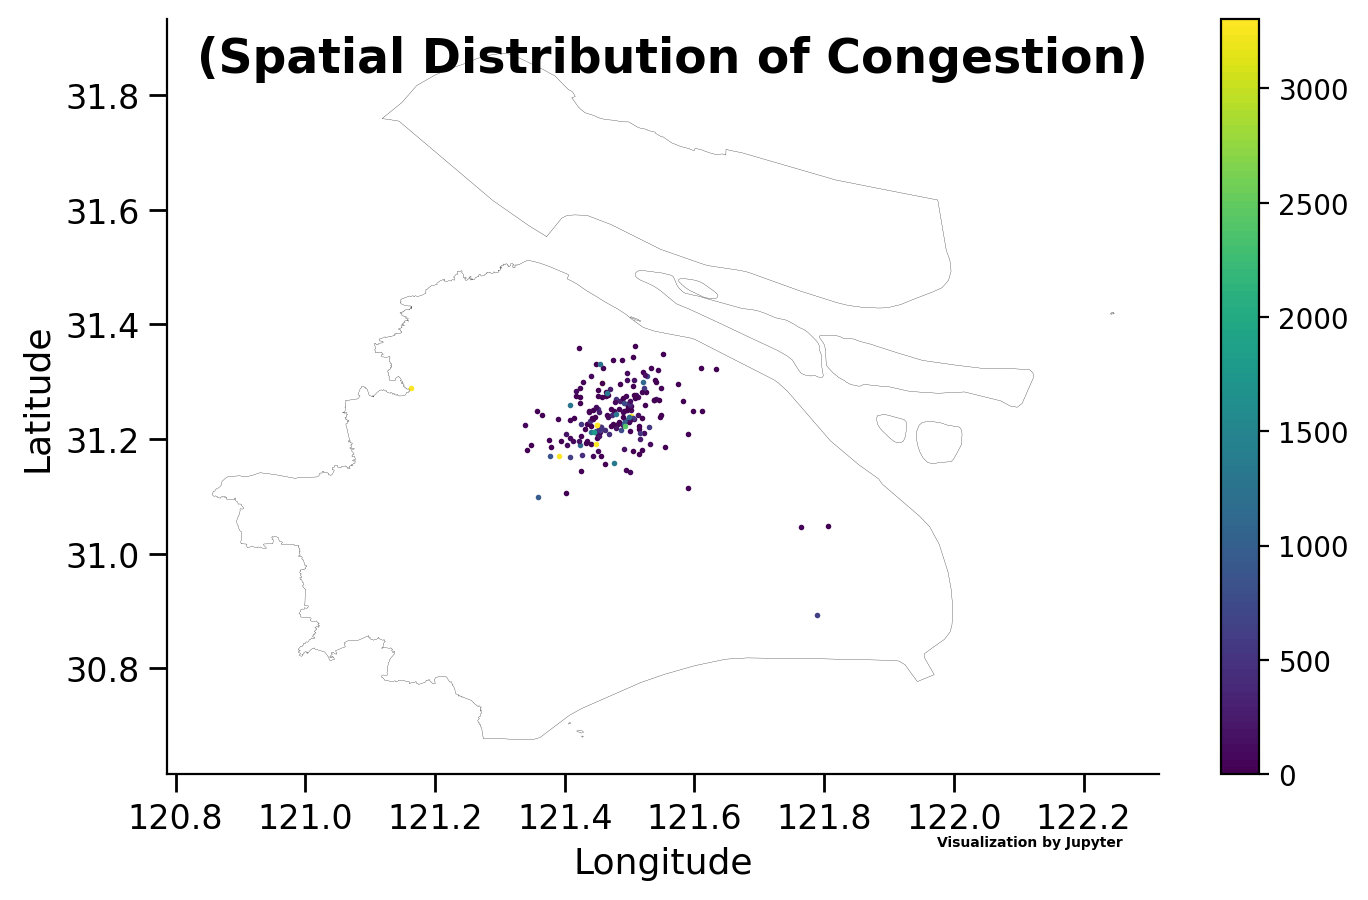

In [7]:
cmap = cm.get_cmap('viridis', 100)
fig,ax = plt.subplots(figsize=(8,5),dpi=200)
for line in sh_poly_lines:
    ax.plot(line[0],line[1],color='black',linewidth=.1)
history=[]
for road,count in road_cgst_cnt.items():
    if 'location' in road_dict[road] and road_dict[road]['location']!=(0.0,0.0) and count!=0:
        np_points=np.array(road_dict[road]['location']).T
        ax.scatter(np_points[0],np_points[1],color=cmap(2*float(count-minium)/float(maxium-minium)),s=1)
        history.append((road[0],count))
        
# for lv,points in road_cgst_statistic.items():
#     if len(points)==0:
#         continue
#     np_points=np.array(points).T
#     c=(lv+1)/(level+1)
#     ax.scatter(np_points[0],np_points[1],color=(c,c,c),s=1)
ax.tick_params(direction='out',labelsize=12,length=6.5,width=1,top=False,right=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('Latitude',fontsize=13)
ax.set_xlabel('Longitude',fontsize=13)
text_font = {'size':'17','weight':'bold','color':'black'}
ax.text(.03,.93,'(Spatial Distribution of Congestion)',transform = ax.transAxes,fontdict=text_font,zorder=4)
ax.text(.87,-.08,'\nVisualization by Jupyter',transform = ax.transAxes, ha='center', va='center',fontsize = 5,color='black',fontweight='bold')
norm = colors.Normalize(vmin=minium, vmax=maxium)
im = cm.ScalarMappable(norm=norm, cmap=cmap)
fig.colorbar(im,ax=ax) 
fig.show()

history=sorted(history, key=lambda item: item[1])
# for item in history:
#     print(item)

In [15]:
cjst_order=sorted(road_cgst_cnt.items(),key=lambda x:x[1], reverse=True)  # 按字典集合中，每一个元组的第二个元素排列。
for e in cjst_order[0:20]:
    print(e)
with open('../data/cjst_order.pkl','wb') as f:
    pickle.dump(cjst_order,f)

(('寿阳路', '从汶水路到江场路'), 3303)
(('陆家嘴西路', '从陆家嘴环路到富城路'), 2943)
(('东园路', '从银城中路到陆家嘴环路'), 2669)
(('普安路', '从金陵中路到淮海中路'), 2228)
(('福山路', '从乳山路到浦东大道'), 2097)
(('沪青平公路', '从外环沪青平立交桥到七莘路'), 2058)
(('铜仁路', '从北京西路到南京西路'), 1992)
(('曹安公路', '从真北路立交桥到外环沪宁立交桥'), 1861)
(('莲花路', '从宜山路到吴中路'), 1859)
(('斜土路', '从南丹东路到天钥桥路'), 1859)
(('曹安公路', '从万镇路到真北路立交桥'), 1780)
(('铜仁路', '从延安中路到南京西路'), 1708)
(('海门路', '从昆明路到东长治路'), 1319)
(('三牌楼路', '从方浜中路到复兴东路'), 1222)
(('福山路', '从浦电路到潍坊路'), 1192)
(('乌鲁木齐中路', '从华山路到淮海中路'), 887)
(('愚园路', '从常德路到万航渡路'), 736)
(('株洲路', '从新同心路到广中路'), 676)
(('泳耀路', '从沿江公路到耀体路'), 662)
(('福建北路', '从福建中路到海宁路'), 654)


## 绘制道路速度变化曲线

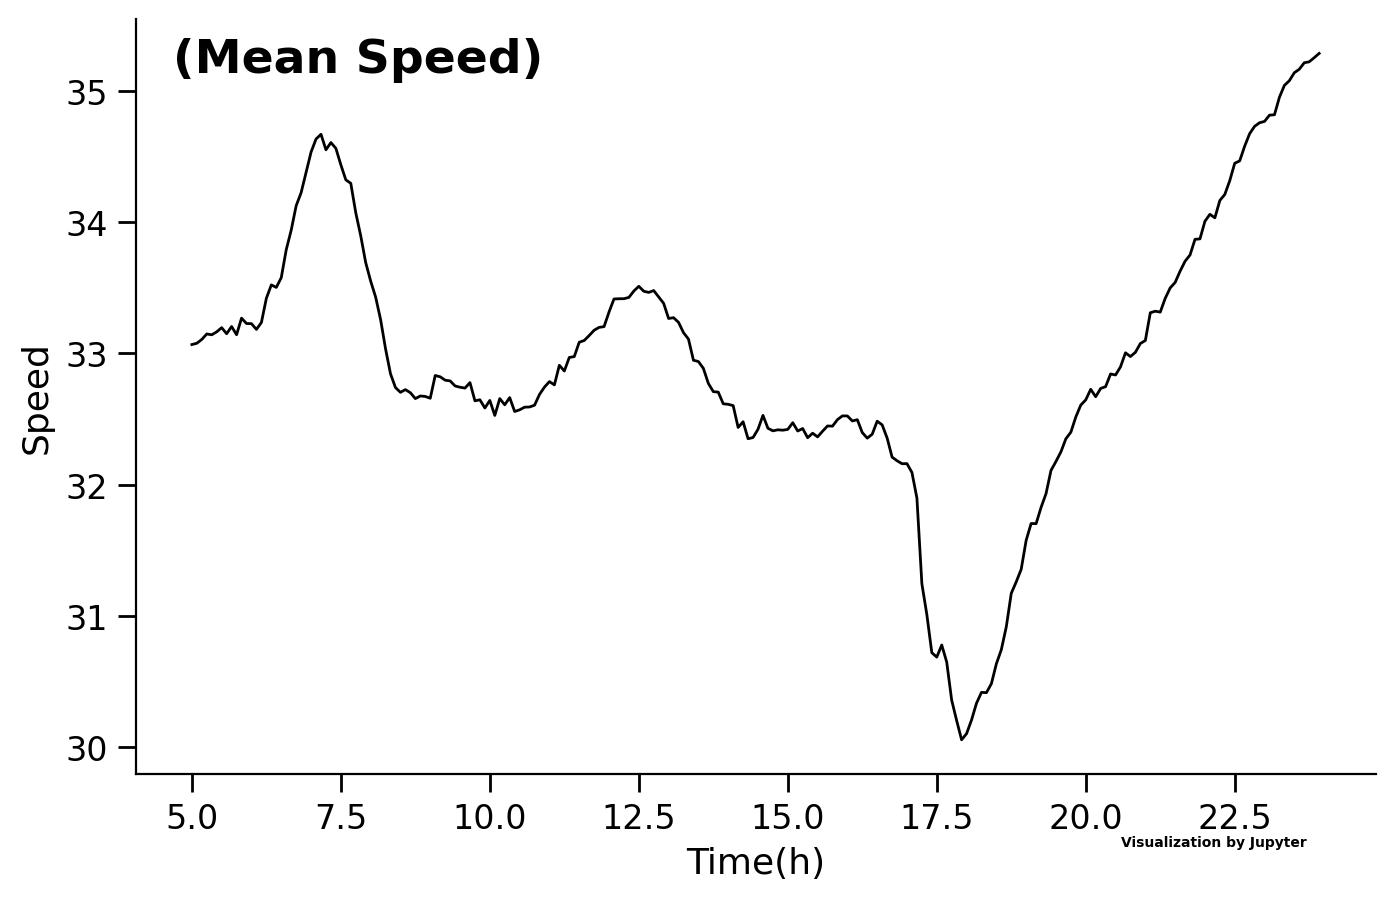

In [15]:
import matplotlib.pyplot as plt
data=np.array(list(road_zip.values()))[:,:,:,1]
data=data.transpose((0,2,1))
data=np.concatenate(data,axis=1)
data=np.mean(data,axis=1)
label = [(i*5)/60+5 for i in range(len(data))]

fig,ax = plt.subplots(figsize=(8,5),dpi=200)
ax.plot(label, data, color='black', linewidth=1)
ax.tick_params(direction='out',labelsize=12,length=6.5,width=1,top=False,right=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('Speed',fontsize=13)
ax.set_xlabel('Time(h)',fontsize=13)
text_font = {'size':'17','weight':'bold','color':'black'}
ax.text(.03,.93,'(Mean Speed)',transform = ax.transAxes,fontdict=text_font,zorder=4)
ax.text(.87,-.08,'\nVisualization by Jupyter',transform = ax.transAxes, ha='center', va='center',fontsize = 5,color='black',fontweight='bold')
fig.show()

(16, 228, 1645)
(228, 1645)


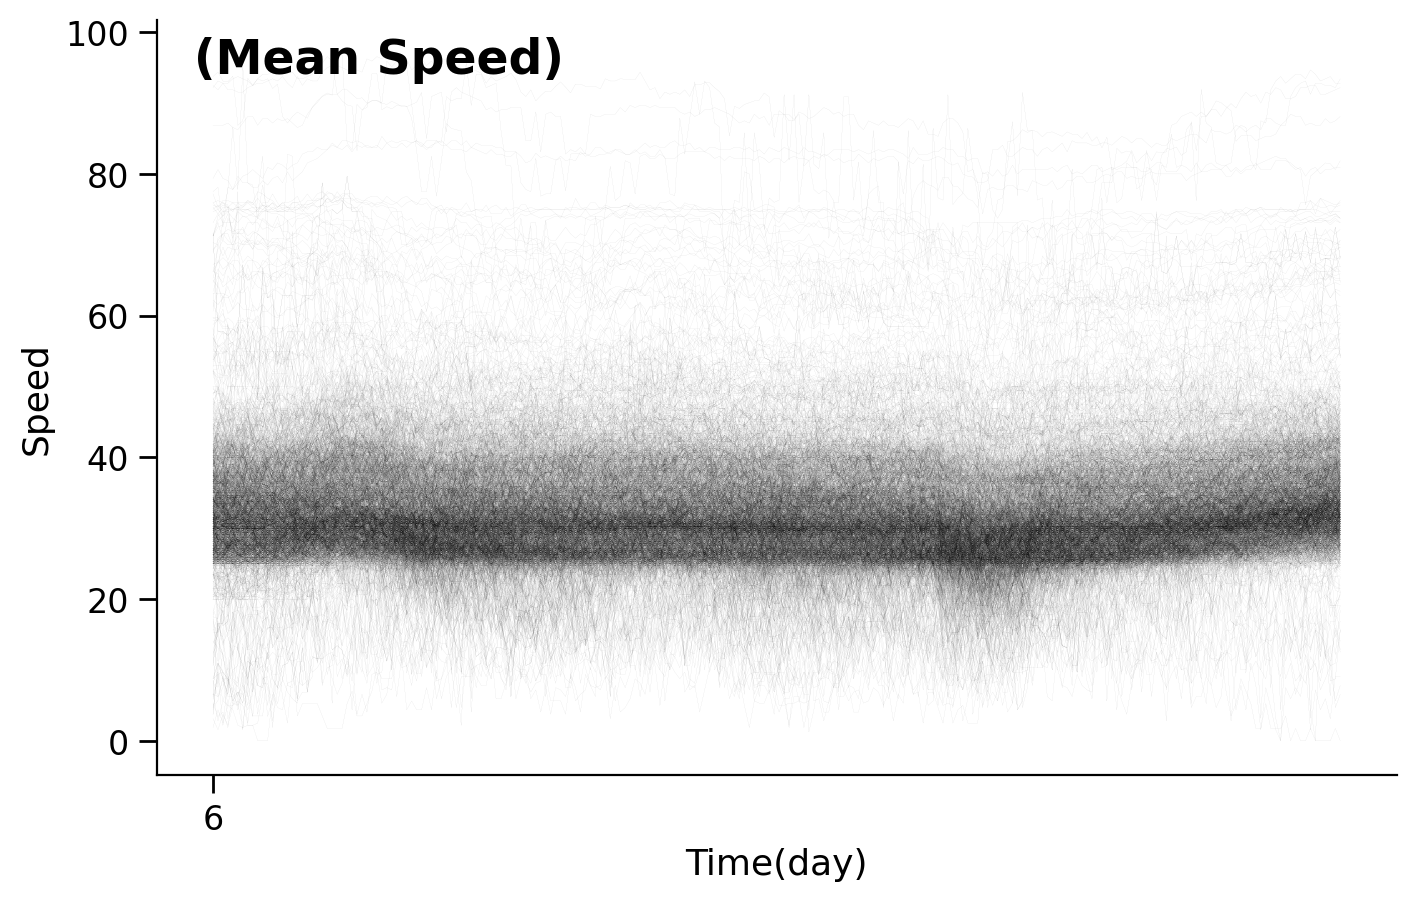

In [14]:
import matplotlib.pyplot as plt
import numpy as np
data=np.array(list(road_zip.values()))[:,:,:,1]
data=data.transpose((1,2,0))
print(data.shape)
data=np.mean(data,axis=0)
#data=np.concatenate(data,axis=0)
print(data.shape)
# data=np.mean(data,axis=1)

day=[f'{int(((i*5)/60)/19+6)}' for i in range(len(data)) if ((i*5)/60)%19==0]
index=[i for i in range(len(data)) if ((i*5)/60)%19==0]
label=[i for i in range(len(data))]

fig,ax = plt.subplots(figsize=(8,5),dpi=200)
ax.plot(label, data, color='black', linewidth=.01)
ax.tick_params(direction='out',labelsize=12,length=6.5,width=1,top=False,right=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('Speed',fontsize=13)
ax.set_xlabel('Time(day)',fontsize=13)
plt.xticks(index,day)
text_font = {'size':'17','weight':'bold','color':'black'}
ax.text(.03,.93,'(Mean Speed)',transform = ax.transAxes,fontdict=text_font,zorder=4)
fig.show()

# 绘制道路状态与归一化速度的关系

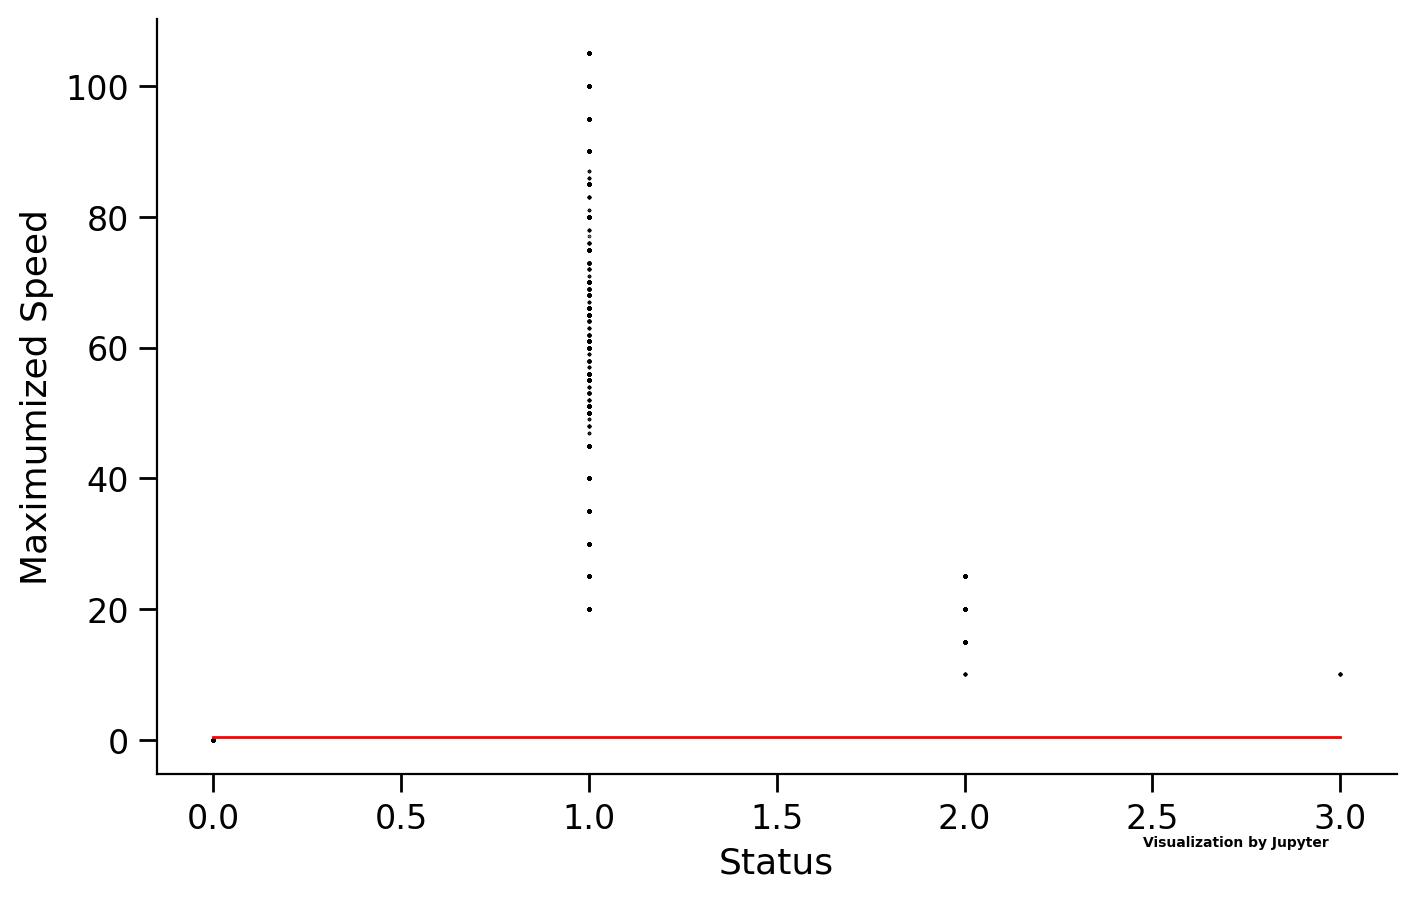

In [17]:
import numpy as np
import matplotlib.pyplot as plt
data=np.array(list(road_zip.values()))[0:100]
data=data.reshape((-1,2))
data=data.T
fig,ax = plt.subplots(figsize=(8,5),dpi=200)
ax.scatter(data[0],data[1],color='black',s=.1)
ax.plot([0,3],[0.5,0.5],color='r',linewidth=1)
ax.tick_params(direction='out',labelsize=12,length=6.5,width=1,top=False,right=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('Maximumized Speed',fontsize=13)
ax.set_xlabel('Status',fontsize=13)
text_font = {'size':'17','weight':'bold','color':'black'}
# ax.text(.03,.93,'(Relationship between status and Maximumized speed)',transform = ax.transAxes,fontdict=text_font,zorder=4)
ax.text(.87,-.08,'\nVisualization by Jupyter',transform = ax.transAxes, ha='center', va='center',fontsize = 5,color='black',fontweight='bold')
fig.show()